# Import Libararies

In [1]:
import cv2 # need cmake for gpu acceleration
import numpy as np
import os
import random
from random import shuffle # shuffle data to randomise input to improve accuracy
import matplotlib.pyplot as plt
import pickle
from prettytable import PrettyTable
import tensorflow as tf
import tqdm
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

# Convert the dataset into numpy arrays, or retrieve pickled objects

In [2]:
train=r"D:\finalconvcough"
cat=["healthypng","covidpng"]
#quick note on data cleaning, you need to first convert the dataset to PNG,␣
#,→then to prevent incomptiable input shapes convert from RGB to Grayscale,␣
#,→then downsample to not fry you CPU with 1000s of images of millions of␣
#,→arrays elements.
data=[]
Model="SPEC"
for i in cat:
    path=os.path.join(train,i)
    label=cat.index(i)
    for img in os.listdir(path):
        img_path=os.path.join(path,img)
        img_arr=cv2.imread(img_path,0)
        #img_arr = tf.reshape(img_arr, [-1, 256, 256, 3]
        #img_arr=tf.image.resize(img_arr, [256,256])#no need
        data.append([img_arr,label])
shuffle(data)
x=[]
y=[]
x_test=[]
y_test=[]
for features,labels in data:
    x.append(features)
    y.append(labels)
x_test=np.array(x[int(len(x)*0.85):-1])
y_test=np.array(y[int(len(y)*0.85):-1])
x=np.array(x[0:int(0.85*len(x))])
y=np.array(y[0:int(0.85*len(y))])
x=x/255
x_test=x_test/255
data.clear()# reduce overhead
print(x.shape)
x=x.reshape(len(x),610,450,1)# for some reason my PC started running out of␣
#,→memory often while training the same model
# so as a solution i tried to treat any image as a grayscale to save 3 times␣
#,→the memory when conveting the image to numpy arrays
# and not exhaust gpu while training the model.
x_test=x_test.reshape(len(x_test),610,450,1)# it worked lol as i expected since␣
#→x.pkl went from 12GB to 4GB


(753, 450, 610)


In [3]:
pickle.dump(x,open('x_spec.pkl','wb'))
pickle.dump(y,open('y_spec.pkl','wb'))
pickle.dump(x_test,open('x_spec_test.pkl','wb'))
pickle.dump(y_test,open('y_spec_test.pkl','wb'))

# Build the CNet

In [ ]:
x=pickle.load(open('x_spec.pkl','rb'))
x_test=pickle.load(open('x_spec_test.pkl','rb'))
y=pickle.load(open('y_spec.pkl','rb'))
y_test=pickle.load(open('y_spec_test.pkl','rb'))

## Calculate the accuracy from a test dataset

In [4]:
def Train():
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64,(3,3),input_shape=x.shape[1:],activation="relu",padding="same"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64,activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(32,activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())


    model.add(tf.keras.layers.Dense(2,activation="softmax"))


    model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=['acc']) # or binary_crossentropy
    model.fit(x,y,epochs=5,validation_split=0.1) # epochs:iteration , validation_split=split your training set to test the model after every epoch
    return model

In [5]:
model=Train()
loss,win=model.evaluate(x_test,y_test)# test using evaluate
print('loss: {}, acc: {}'.format(loss,win))
model.summary()

Epoch 1/5
22/22 [==============================] - 104s 4s/step - loss: 0.2626 - acc: 0.8992 - val_loss: 2.0350 - val_acc: 0.6316
Epoch 2/5
22/22 [==============================] - 101s 5s/step - loss: 0.1311 - acc: 0.9546 - val_loss: 12.1617 - val_acc: 0.3684
Epoch 3/5
22/22 [==============================] - 103s 5s/step - loss: 0.0817 - acc: 0.9845 - val_loss: 0.3105 - val_acc: 0.9474
Epoch 4/5
22/22 [==============================] - 105s 5s/step - loss: 0.0610 - acc: 0.9914 - val_loss: 0.5578 - val_acc: 0.8816
Epoch 5/5
5/5 [==============================] - 5s 881ms/step - loss: 0.2740 - acc: 0.9394
loss: 0.2739979922771454, acc: 0.939393937587738
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 610, 450, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 305, 225, 64)     

# Random Forest Classifier

In [ ]:
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
predict=model.predict([x_test])
xp=x.reshape(len(x),610*450)
p=x_test.reshape(len(x_test),610*450)
rf.fit(xp, y)
y_pred_rf = rf.predict_proba(p)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
f_predict=[]
def simpleargmax(n):
    if list(n).index(max(n))==0:
        return 0
    elif list(n).index(max(n))==1:
        return 1
for i in range(len(p)):
    f_predict.append(simpleargmax(predict[i]))
auc_rf = auc(f_predict, y_test)
print(auc_rf)

## Saving the model after achieving 89% percentage

In [6]:
model.save("Spec")

INFO:tensorflow:Assets written to: Spec\assets


In [ ]:
model=tf.keras.models.load_model("Spec")

# Strandradized Table for the model acuuaracy and after 30 runs.

In [ ]:
for i in range(30):
    model=Train()
    test=model.evaluate(x_test,y_test)
    with open(r'avg.txt','a+') as file:
        file.write("{},{}\n".format(test[1],test[0]))

# Confusion Matrix 

True


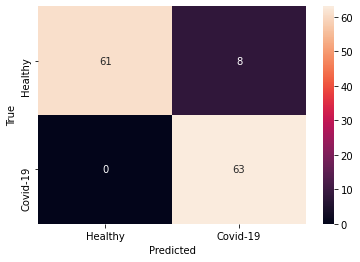

In [7]:
singlepredict=[]
singletest=[]
predict=model.predict([x_test])
tf.config.run_functions_eagerly(True)
print(tf.executing_eagerly())# if false then confusion.numpy will produce error
singlepredict=np.argmax(predict,1)
singletest=np.array(y_test)
confusion=tf.math.confusion_matrix(labels=singletest, predictions=singlepredict).numpy()
#plt.imshow(confusion) # Green Confusion Matrix
sns.heatmap(confusion , annot=True , xticklabels=['Healthy' , 'Covid-19'] , yticklabels=['Healthy' , 'Covid-19'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Metrics

In [8]:
precision, recall, f1, _ = score(singletest, singlepredict)
print('Precision: {}, Aversge: {}'.format(precision,sum(precision)/len(precision)))
print('Recall: {}, Average: {}'.format(recall,sum(recall)/len(recall)))
print('F-score: {}, Average: {}'.format(f1,sum(f1)/len(f1)))


Precision: [1.         0.88732394], Aversge: 0.943661971830986
Recall: [0.88405797 1.        ], Average: 0.9420289855072463
F-score: [0.93846154 0.94029851], Average: 0.9393800229621125


In [ ]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_acc']
val_loss = model.history.history['val_loss']
loss = model.history.history['loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, [i*100 for i in acc], 'green', label='Training acc')
plt.plot(epochs,[i*100 for i in val_acc], 'blue', label='Validation acc')

plt.plot(epochs, [i*100 for i in loss], 'red', label='Training loss')
plt.plot(epochs,[i*100 for i in val_loss], 'black', label='Validation loss')
plt.title('Training, validation accuaracy and loss over epochs')#'Training and validation loss'
plt.legend()

plt.show()

# Some visulization into some cases in the dataset, the prediction and the true output.

In [ ]:
predict=model.predict([x_test]) # ignore if you run the cells above

In [ ]:
def simpleargmax(n):
    if list(n).index(max(n))==0:
        return "Healthy"
    elif list(n).index(max(n))==1:
        return "COVID-19"
def label(m):
    if m==0:
        return "Healthy"
    elif m==1:
        return "COVID-19"
for i in range(30):
    plt.figure(figsize = (2.5,2.5))
    val=random.randint(0,len(x_test)-1)
    plt.axis("off")
    plt.imshow(x_test[val])
    plt.title("Prediction:{}. True:{}".format(simpleargmax(predict[val]),label(y_test[val])))
    plt.show()